In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

In [2]:
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)
pos = nx.spring_layout(G, k=3, seed=99192, weight=None)

In [3]:
nx.average_shortest_path_length(G)

1.6888888888888889

In [14]:
N = len(G.nodes)
ONE_YEAR = 16_000 # time steps equal to one year

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, ONE_YEAR//3)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (10*0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.9
g = 0.008
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 600
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

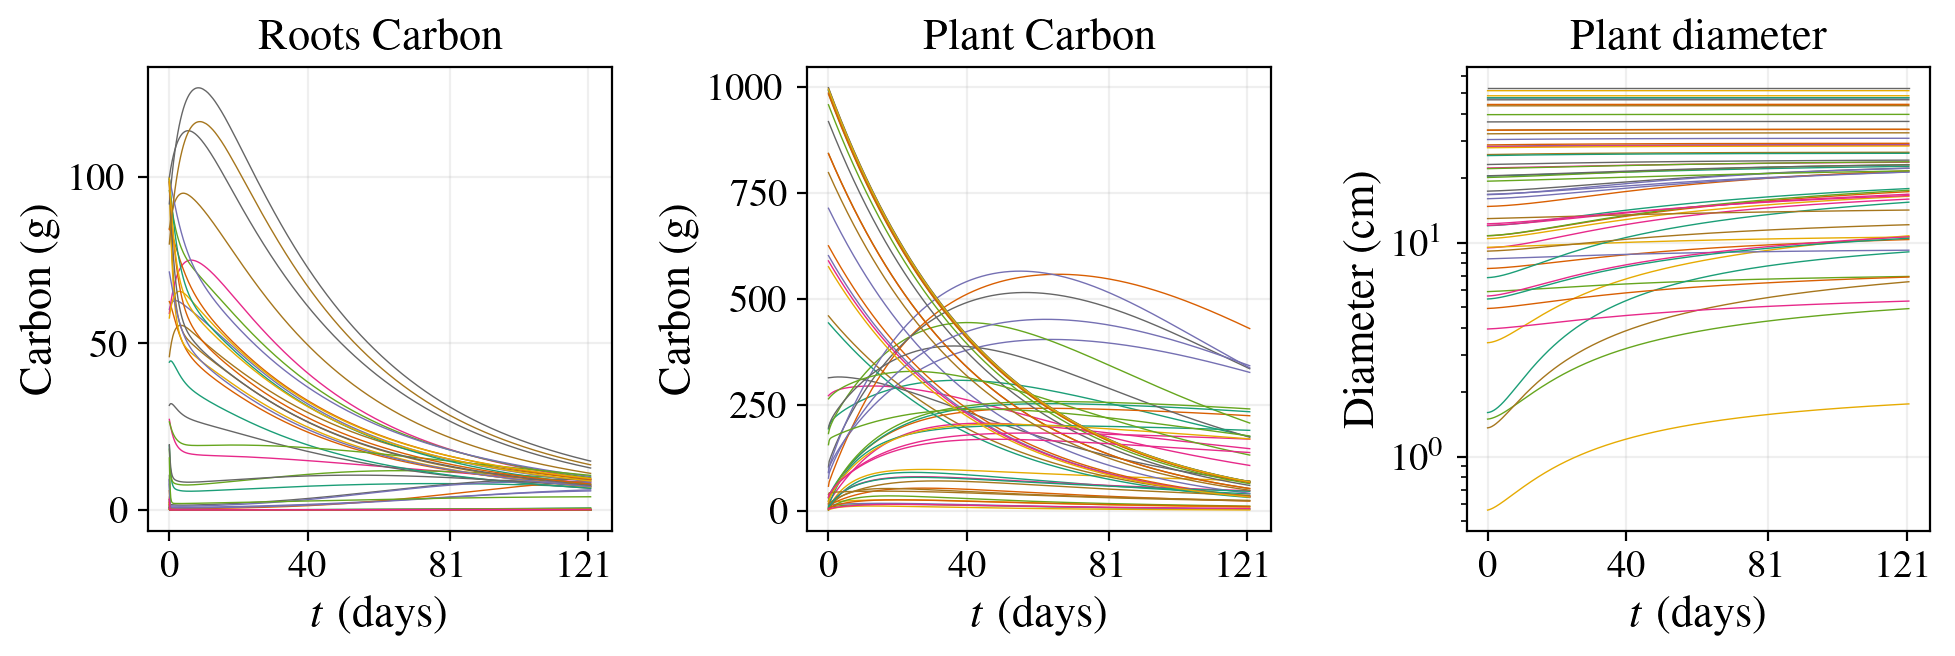

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

t_in_days = (t/t_range[1])*(365./(ONE_YEAR/t_range[1]))

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t_in_days, z[i], linewidth=0.5)
    axes[0].set_ylabel("Carbon (g)")
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t_in_days, z[i], linewidth=0.5)
    axes[1].set_ylabel("Carbon (g)")
    
axes[2].set_title("Plant diameter")
for i in range(2*N, 3*N):
    axes[2].plot(t_in_days, z[i], linewidth=0.5)
    axes[2].set_ylabel("Diameter (cm)")
    axes[2].set_yscale("log")
    
for ax in axes:
    ax.set_xlabel("$t$ (days)")
    ax.set_xticks(np.linspace(0, t_in_days[-1], 4, dtype=int))

plt.tight_layout()
plt.show()

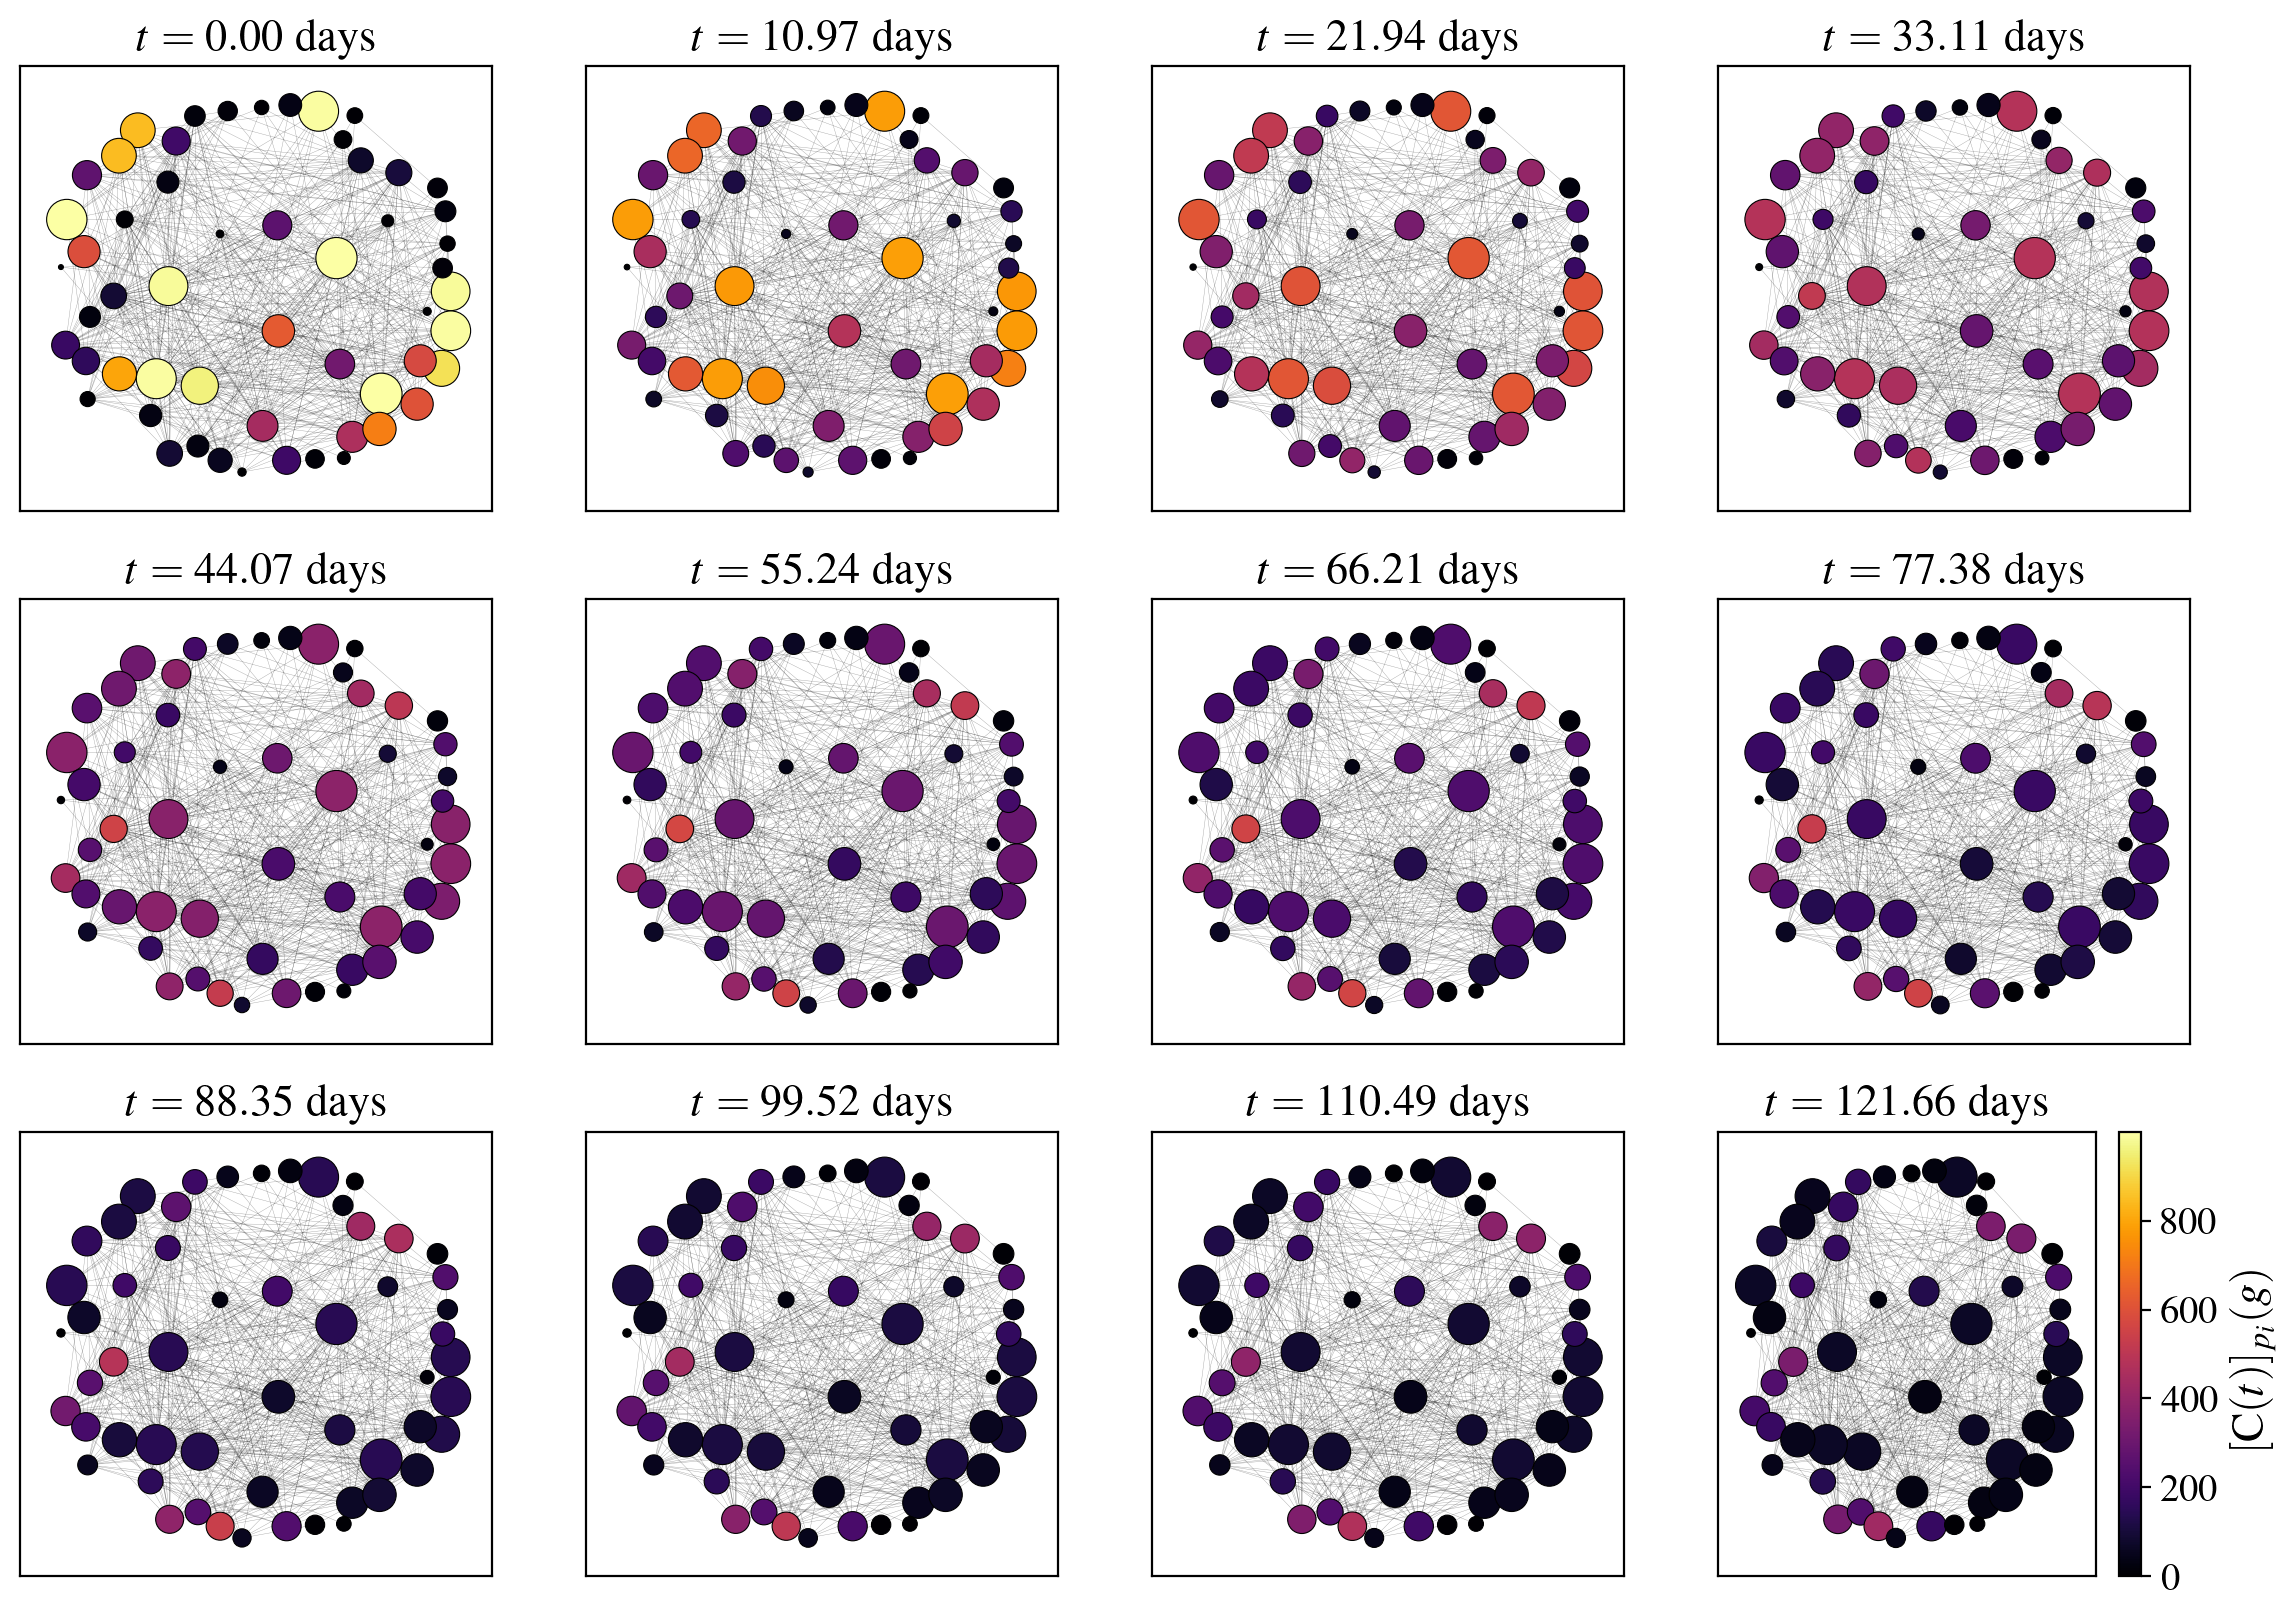

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 10))

steps = np.linspace(0, (time_steps)-1, 12, dtype=int)

plant_carbon_data = [z[N:2*N,step] for step in steps]
min_carbon, max_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

diameter_data = z[2*N:,:]
max_diameter = np.max(diameter_data)

nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)
    
cmap = mpl.cm.inferno

for j, ax in enumerate(axes.flat):
    time = (t[steps[j]]/t_range[1])*(365./(ONE_YEAR/t_range[1])) # time in days
    ax.set_title(f"$t = {time:.2f}$ days")
    ax.grid(False)
    
    plant_carbon_vals_t = z[:,steps[j]][N:2*N]
    diameter_vals_t = (z[:,steps[j]][2*N:3*N])/max_diameter
    diameter_vals_log = np.log(1 + 0.7*diameter_vals_t)*425
   
    edges = nx.draw_networkx_edges(G, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
    edges.set_zorder(-1)
    
    # set correct z-index for nodes so small nodes don't get hidden behind big nodes. hacky but works :)
    for i, (cohort, nodes) in enumerate(nodes_by_cohort.items()):
        H = G.subgraph(nodes)
        node_idxs = [node_list.index(node) for node in nodes]
        collection = nx.draw_networkx_nodes(
            H, pos=pos, node_size=diameter_vals_log[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
            edgecolors="black", linewidths=0.4, cmap=cmap, ax=ax, vmin=0, vmax=max_carbon)
        collection.set_zorder(4 - i)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_carbon))
cbar = plt.colorbar(sm)
cbar.set_label(r"$[\text{C}(t)]_{p_i} (g)$")
    
plt.show()

In [17]:
def animate_frames(z, folder):
    import gc
    
    plant_carbon_data = [z[N:2*N,step] for step in range(len(z))]
    min_carbon, max_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

    diameter_data = z[2*N:,:]
    max_diameter = np.max(diameter_data)
    
    for j in range(time_steps):
        filename = f"movie_frames/{folder}/{j:04}.png"
        fig, ax = plt.subplots(figsize=(5.5, 5.3), dpi=200)

        time = (t[j]/t_range[1])*(365./(ONE_YEAR/t_range[1])) # time in days
        ax.set_title(f"$t = {time:.2f}$ days")

        plant_carbon_vals_t = z[:,j][N:2*N]
        diameter_vals_t = (z[:,j][2*N:3*N])/max_diameter
        diameter_vals_log = np.log(1 + diameter_vals_t)*1000

        edges = nx.draw_networkx_edges(G, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
        edges.set_zorder(-1)

        # set correct z-index for nodes so small nodes don't get hidden behind big nodes. hacky but works :)
        for i, (cohort, nodes) in enumerate(nodes_by_cohort.items()):
            H = G.subgraph(nodes)
            node_idxs = [node_list.index(node) for node in nodes]
            collection = nx.draw_networkx_nodes(
                H, pos=pos, node_size=diameter_vals_log[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
                edgecolors="black", linewidths=0.4, cmap=cmap, ax=ax, vmin=0, vmax=max_carbon)
            collection.set_zorder(4 - i)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_carbon))
        cbar = plt.colorbar(sm, location="bottom", aspect=50, pad=0.005)
        cbar.set_label(r"$[\text{C}(t)]_{p_i}$ (g)", fontsize=12)
        
        plt.gca().set_axis_off()
        plt.savefig(filename, facecolor='white', transparent=False, bbox_inches="tight")

        # https://stackoverflow.com/questions/7101404/how-can-i-release-memory-after-creating-matplotlib-figures
        plt.clf()
        plt.close()
        gc.collect()
        
animate_frames(z, "growth_and_carbon")